# Publication Figure 2

This jupyter notebook contains the Analysis code for an upcoming publication.

Authors: Kevin Sawade (kevin.sawade@uni-konstanz.de), Christine Peter (christine.peter@uni-konstanz.de)

EncoderMap's featurization was inspired by the (no longer maintained) PyEMMA library. Consider citing it (https://dx.doi.org/10.1021/acs.jctc.5b00743), if you are using EncoderMap:

## Imports

We start with the imports.

In [1]:
# Future imports at the top
from __future__ import annotations

# Import EncoderMap
import encodermap as em
from encodermap.plot import plotting
from encodermap.plot.plotting import _plot_free_energy

# Builtin packages
import re
import io
import warnings
import os
import json
import contextlib
import time
from copy import deepcopy
from types import SimpleNamespace
from pathlib import Path

# Math
import numpy as np
import pandas as pd
import xarray as xr

# ML
import tensorflow as tf

# Plotting
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
from plotly.subplots import make_subplots
import plotly.io as pio

# MD
import mdtraj as md
import MDAnalysis as mda
import nglview as nv

# dates
from dateutil import parser

/home/kevin/git/encoder_map_private/encodermap/__init__.py:194: GPUsAreDisabledWarning: EncoderMap disables the GPU per default because most tensorflow code runs with a higher compatibility when the GPU is disabled. If you want to enable GPUs manually, set the environment variable 'ENCODERMAP_ENABLE_GPU' to 'True' before importing EncoderMap. To do this in python you can run:

import os; os.environ['ENCODERMAP_ENABLE_GPU'] = 'True'

before importing encodermap.
  _warnings.warn(


Using Autoreload we can make changes in the EncoderMap source code and use the new code, without needing to restart the Kernel.

In [2]:
%load_ext autoreload
%autoreload 2

## Trained network weights

EncoderMap's Neural Network is initialized with random weights and biases. While the training is deterministic with pre-defined training weights, and the inferences that can be made from two trained models are qualitatively similar, the numerical exact output depends on the starting weights.

For this reason, the trained network weights are available from the corresponding authors upon reasonable request or by raising an issue on GitHub: https://github.com/AG-Peter/encodermap/issues

For this figure, data from Berg et al. is used.

```
@article{berg2018towards,
  title={Towards a molecular basis of ubiquitin signaling: A dual-scale simulation study of ubiquitin dimers},
  author={Berg, Andrej and Kukharenko, Oleksandra and Scheffner, Martin and Peter, Christine},
  journal={PLoS computational biology},
  volume={14},
  number={11},
  pages={e1006589},
  year={2018},
  publisher={Public Library of Science San Francisco, CA USA}
}
```

### Load MD data from KonDATA

The necessary simulations have also been uploaded to KonDATA and can be obtained from there.

In [3]:
figure_2_data_dir = Path.cwd() / "analysis/figure_2"
figure_2_data_dir = em.get_from_kondata(
    "linear_dimers",
    figure_2_data_dir,
    mk_parentdir=True,
    silence_overwrite_message=True,
)

Output()

From the downloaded files, a trajectory ensemble can be constructed.

In [4]:
xtc_files = list(Path(figure_2_data_dir).rglob("*.xtc"))
for file in xtc_files:
    print(file.relative_to(Path.cwd()))
pdb_files = []
for file in xtc_files:
    pdb_file = file.with_suffix(".pdb")
    pdb_files.append(pdb_file)
linear_dimers_trajs = em.load(xtc_files, pdb_files)
linear_dimers_trajs

analysis/figure_2/11.xtc
analysis/figure_2/02.xtc
analysis/figure_2/06.xtc
analysis/figure_2/03.xtc
analysis/figure_2/12.xtc
analysis/figure_2/10.xtc
analysis/figure_2/07.xtc
analysis/figure_2/05.xtc
analysis/figure_2/04.xtc
analysis/figure_2/01.xtc
analysis/figure_2/09.xtc
analysis/figure_2/08.xtc


<encodermap.TrajEnsemble object. Current backend is no_load. Containing 12 trajectories. Not containing any CVs. Object at 0x7d53a5c238b0>

### Featurize

Because the proteins in this dataset contain just standard residues, extracting the features needed for EncoderMap can be done via.

In [5]:
linear_dimers_trajs.load_CVs("all")

Getting output of 5 features for 11:   0%|          | 0/5 [00:00<?, ?it/s]

Getting output of 5 features for 02:   0%|          | 0/5 [00:00<?, ?it/s]

Getting output of 5 features for 06:   0%|          | 0/5 [00:00<?, ?it/s]

Getting output of 5 features for 03:   0%|          | 0/5 [00:00<?, ?it/s]

Getting output of 5 features for 12:   0%|          | 0/5 [00:00<?, ?it/s]

Getting output of 5 features for 10:   0%|          | 0/5 [00:00<?, ?it/s]

Getting output of 5 features for 07:   0%|          | 0/5 [00:00<?, ?it/s]

Getting output of 5 features for 05:   0%|          | 0/5 [00:00<?, ?it/s]

Getting output of 5 features for 04:   0%|          | 0/5 [00:00<?, ?it/s]

Getting output of 5 features for 01:   0%|          | 0/5 [00:00<?, ?it/s]

Getting output of 5 features for 09:   0%|          | 0/5 [00:00<?, ?it/s]

Getting output of 5 features for 08:   0%|          | 0/5 [00:00<?, ?it/s]

### Create EncoderMap

We will use the same parameters, as the EncoderMap II publication.

In [6]:
total_steps = 50_000

p = em.ADCParameters(
    main_path=em.misc.run_path("/tmp/runs"),
    n_steps=total_steps,
    cartesian_cost_scale=1,
    cartesian_cost_variant="mean_abs",
    cartesian_cost_scale_soft_start=(
        int(total_steps / 10 * 9),
        int(total_steps / 10 * 9) + total_steps // 50,
    ),
    cartesian_pwd_start=1,
    cartesian_pwd_step=3,
    dihedral_cost_scale=1,
    dihedral_cost_variant="mean_abs",
    distance_cost_scale=0,
    cartesian_distance_cost_scale=100,
    cartesian_dist_sig_parameters=[40, 10, 5, 1, 2, 5],
    checkpoint_step=max(1, int(total_steps / 10)),
    l2_reg_constant=0.001,
    center_cost_scale=0,
    use_backbone_angles=True,
    tensorboard=True,
    summary_step=1,
    track_clashes=True,
    track_RMSD=True,
)

In [7]:
linear_dimers_emap = em.AngleDihedralCartesianEncoderMap(trajs=linear_dimers_trajs, parameters=p)

Output files are saved to /tmp/runs/run0 as defined in 'main_path' in the parameters.
input shapes are:
{'central_cartesians': (60012, 456, 3), 'central_dihedrals': (60012, 453), 'central_angles': (60012, 454), 'central_distances': (60012, 455), 'side_dihedrals': (60012, 322)}
Saved a text-summary of the model and an image in /tmp/runs/run0, as specified in 'main_path' in the parameters.


Check, whether the RMSD metric is active.

In [8]:
linear_dimers_emap.metrics

### Train / Load trained network

In [9]:
if input(
    "Training this model takes a lot of computational resources. "
    "If you just want to look at the images, we recommend loading "
    "a trained model from the provided files. Train y/N?"
) == "y":
    history = linear_dimers_emap.train()
    json.dump(history, open(emap.p.main_path / "history.json", 'w'))
else:
    figure_2_trained_nn_dir = Path.cwd() / "trained_networks/figure_2"
    linear_dimers_emap = em.AngleDihedralCartesianEncoderMap.from_checkpoint(
        trajs=linear_dimers_trajs,
        checkpoint_path=figure_2_trained_nn_dir,
    )

Training this model takes a lot of computational resources. If you just want to look at the images, we recommend loading a trained model from the provided files. Train y/N? 


Seems like the parameter file was moved to another directory. Parameter file is updated ...
Output files are saved to /home/kevin/git/encoder_map_private/docs/source/notebooks/publication/trained_networks/figure_2 as defined in 'main_path' in the parameters.
input shapes are:
{'central_cartesians': (60012, 456, 3), 'central_dihedrals': (60012, 453), 'central_angles': (60012, 454), 'central_distances': (60012, 455), 'side_dihedrals': (60012, 322)}
Saved a text-summary of the model and an image in /home/kevin/git/encoder_map_private/docs/source/notebooks/publication/trained_networks/figure_2, as specified in 'main_path' in the parameters.


### Images

The `history` dictionary, that is returned from EncoderMap, when the training concludes contains the necessary information to plot the RMSD metric. A `.json` file of this dictionary can be requested from the corresponding authors.

In [10]:
with open(figure_2_trained_nn_dir / "history.json", "r") as f:
    rmsd_data = np.asarray(json.loads(f.read())["ADCRMSDMetric"])
rmsd_data.shape

(50000, 256)

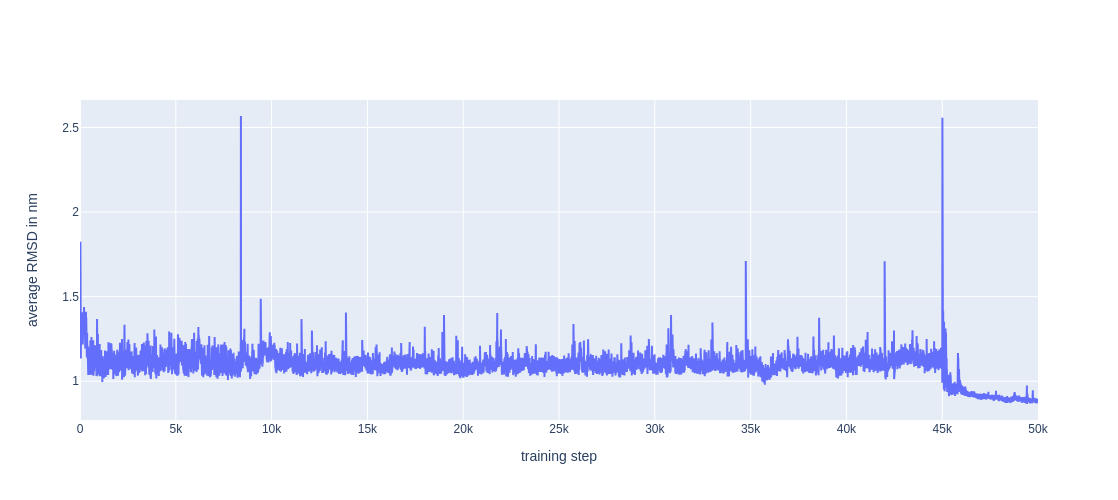

In [11]:
fig = go.Figure(
    data=[
        go.Scatter(
            y=np.mean(rmsd_data, axis=1),
            x=np.arange(len(rmsd_data)),
        )
    ]
)
fig.update_layout(
    {
        "width": 1000,
        "height": 500,
        "xaxis": {
            "title": "training step",
        },
        "yaxis": {
            "title": "average RMSD in nm",
        },
    }
)
# fig.write_image(figure_2_trained_nn_dir / "figure2_A.svg", scale=2)
# fig.write_image(figure_2_trained_nn_dir / "figure2_A.png", scale=2)
fig.show()

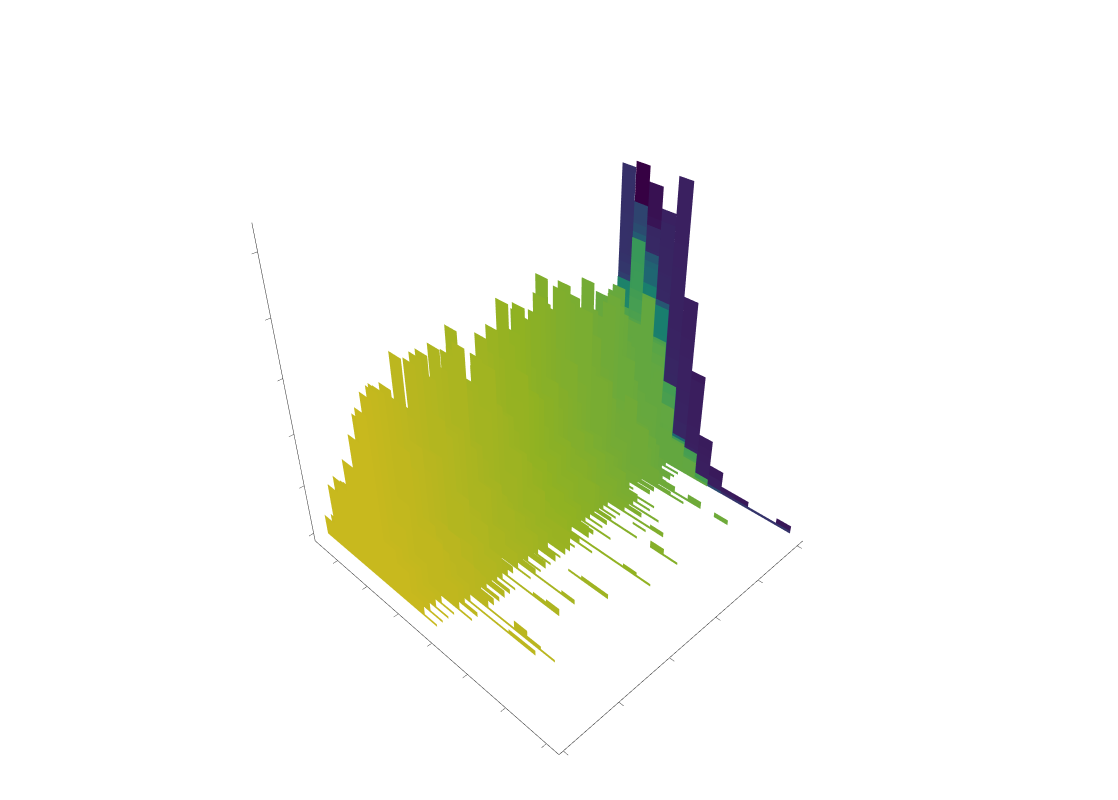

In [13]:
from plotly.express.colors import sample_colorscale
N_BINS = 21
step = 1000

rmsd_plot_data = np.concatenate(
    [
        rmsd_data[:200:1],
        rmsd_data[200::step],
    ],
)
train_steps = np.concatenate(
    [
        np.arange(200),
        np.arange(200, len(rmsd_data))[::step]
    ],
)
assert len(rmsd_plot_data) == len(train_steps)

fig = go.Figure()

min_overall = float("inf")
max_overall = 0

for train_step, rmsds in enumerate(rmsd_plot_data):
    if (new_min := np.min(rmsds)) < min_overall:
        min_overall = new_min
    if (new_max := np.max(rmsds)) > max_overall:
        max_overall = new_max
edges = np.linspace(min_overall, max_overall, N_BINS)
centers = np.mean(np.vstack([edges[0:-1], edges[1:]]), axis=0)


def triangulate_histogtam(x, y, z):
    if len(x) != len(y) != len(z) :
        raise ValueError("The  lists x, y, z, must have the same length")
    n = len(x)
    if n % 2 :
        raise ValueError("The length of lists x, y, z must be an even number") 
    pts3d = np.vstack((x, y, z)).T
    pts3dp = np.array([[x[2*k+1], y[2*k+1], 0] for k in range(1, n//2-1)])
    pts3d = np.vstack((pts3d, pts3dp))
    #triangulate the histogram bars:
    tri = [[0,1,2], [0,2,n]]
    for k, i  in zip(list(range(n, n-3+n//2)), list(range(3, n-4, 2))):
        tri.extend([[k, i, i+1], [k, i+1, k+1]])
    tri.extend([[n-3+n//2, n-3, n-2], [n-3+n//2, n-2, n-1]])      
    return pts3d, np.array(tri)


for i, (train_step, rmsds) in enumerate(zip(train_steps, rmsd_plot_data)):
    c = i / len(rmsd_plot_data)
    c = sample_colorscale("Viridis", c)[0]
    H = np.histogram(rmsds, edges)[0]
    a0 = np.repeat(H, 2).tolist()
    a0.insert(0,0)
    a0.pop()
    a0[-1]=0
    a1 = np.repeat(centers, 2)
    verts, tri = triangulate_histogtam([train_step]*len(a0), a1, a0)
    x, y, z = verts.T
    I, J, K = tri.T
    fig.add_traces(
        go.Mesh3d(
            x=x,
            y=y,
            z=z,
            i=I,
            j=J,
            k=K,
            color=c,
        ),
    )
    
fig.update_layout(
    template="simple_white",
)
fig.update_layout(
    {
        "width": 800,
        "height": 800,
        "scene": {
            "xaxis": {
                "title": {
                    "text": "training step",
                    "font": {
                        "size": 22,
                    },
                },
                "tickfont": {
                    "size": 16,
                },
            },
            "yaxis": {
                "title": {
                    "text": "RMSD in nm",
                    "font": {
                        "size": 22,
                    },
                },
                "tickfont": {
                    "size": 16,
                },
            },
            "zaxis": {
                "title": {
                    "text": "count",
                    "font": {
                        "size": 22,
                    },
                },
                "tickfont": {
                    "size": 16,
                },
            },
        },
        "scene_camera": {
            "eye": {
                "x": 1.45,
                "y": 1.45,
                "z": 1.45,
            },
        },
        "margin": {
            "t": 0,
            "b": 0,
            "r": 0,
            "l": 0,
        },
    }
)
# fig.write_image(figure_2_trained_nn_dir / "figure2_B.svg", scale=2)
# fig.write_image(figure_2_trained_nn_dir / "figure2_B.png", scale=2)
fig.show()